## Batch Size CodeChallenge

In [121]:
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data.shape

(1599, 12)

In [5]:
cols_zscore = data.keys().drop("quality")

In [6]:
data = data[data["total sulfur dioxide"]<200]
data[cols_zscore] = data[cols_zscore].apply(stats.zscore)
data['bool_quality'] = 0
data["bool_quality"][data['quality']>5] = 1

C:\Users\pablo\AppData\Local\Temp\ipykernel_17864\1252206575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["bool_quality"][data['quality']>5] = 1


In [7]:
data[["quality", "bool_quality"]].head()

,quality,bool_quality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0


In [8]:
X = torch.tensor(data[cols_zscore].values).float()
y = torch.tensor(data["bool_quality"].values).float()

y = y.reshape(-1,1)
#y = y[:,None]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, drop_last=True)
#drop_last se asegura de quitar el último batch con tamaño diferente

test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [52]:
def get_train_dataloader(batch_size):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, drop_last=True)
    
    return train_loader

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
X_train.shape

torch.Size([1197, 11])

<img src="model.png" alt="info" width=500>

In [46]:
class Model(nn.Module):
    
    
    def __init__(self):
        
        super().__init__()
        self.inp = nn.Linear(X_train.shape[1], 16)
        self.hid1 = nn.Linear(16, 32)
        self.hid2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, 1)
        
    
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        x = F.relu(self.hid1(x))
        x = F.relu(self.hid2(x))
        x = self.out(x)
        
        return x

In [47]:
def build_model():
    
    model = Model()
    loss_func = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(params=model.parameters(), 
                           lr=0.01)
    
    return model, loss_func, optim

def train_model(model, loss_func, optim, n_epochs):

    losses = torch.zeros(n_epochs)
    train_accs = []
    test_accs = []
    
    for epoch in range(n_epochs):
        
        model.train()
        
        for (X_batch, y_batch) in train_loader:
            
            batch_train_accs = []
            batch_losses = []
            
            y_hat = model(X_batch) #forward pass
            
            loss = loss_func(y_hat, y_batch) #compute error
            
            optim.zero_grad() #clear gradient cache
            loss.backward()
            optim.step() #update parameters
            
            
            #store accuracies & losses
            batch_train_accs.append(100*torch.mean(((y_hat>0) == y_batch).float()).item())
            batch_losses.append(loss.item())
        
        train_accs.append(np.mean(batch_train_accs))
        losses[epoch] = np.mean(batch_losses)
        
        model.eval()
        X_test, y_test = next(iter(test_loader))

        with torch.no_grad():
            y_pred = model(X_test)

        test_accs.append(100*torch.mean(((y_pred>0) == y_test).float()).item())
        
    
    return losses, train_accs, test_accs
            
    
        

In [48]:
model, loss_func, optim = build_model()
losses, train_accs, test_accs = train_model(model, loss_func, optim, n_epochs=1000)

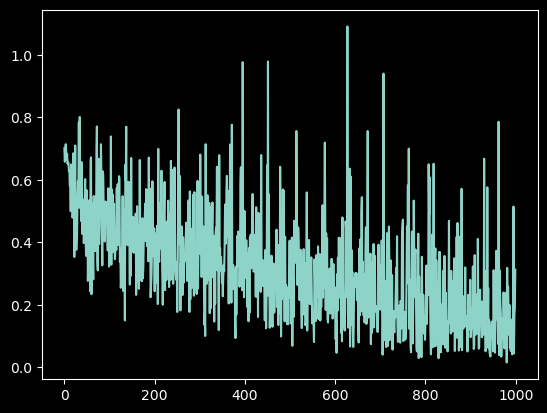

In [49]:
plt.plot(losses);

## Experimento

In [50]:
n_epochs = 1000

In [53]:
import time
from tqdm import tqdm

In [70]:
batch_sizes = 2**np.arange(1, 10, 2)

exp_losses = np.zeros((n_epochs, len(batch_sizes)))
exp_train_accs = np.zeros((n_epochs, len(batch_sizes)))
exp_test_accs = np.zeros((n_epochs, len(batch_sizes)))
comp_times = np.zeros((len(batch_sizes)))


for batch_idx in tqdm(range(len(batch_sizes))):
    
    start_time = time.process_time() #start counting time
    train_loader = get_train_dataloader(int(batch_sizes[batch_idx]))
    
    model, loss_func, optim = build_model()
    losses, train_accs, test_accs = train_model(model, loss_func, optim, n_epochs)
    
    #store results
    exp_train_accs[:,batch_idx] = train_accs
    exp_test_accs[:,batch_idx] = test_accs
    exp_losses[:, batch_idx] = losses
    
    comp_times[batch_idx] = time.process_time() - start_time #actual time - beginning
    

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:37<00:00, 127.46s/it]


In [123]:
%config InlineBackend.figure_formats = ['svg']

In [72]:
exp_train_accs.shape

(1000, 5)

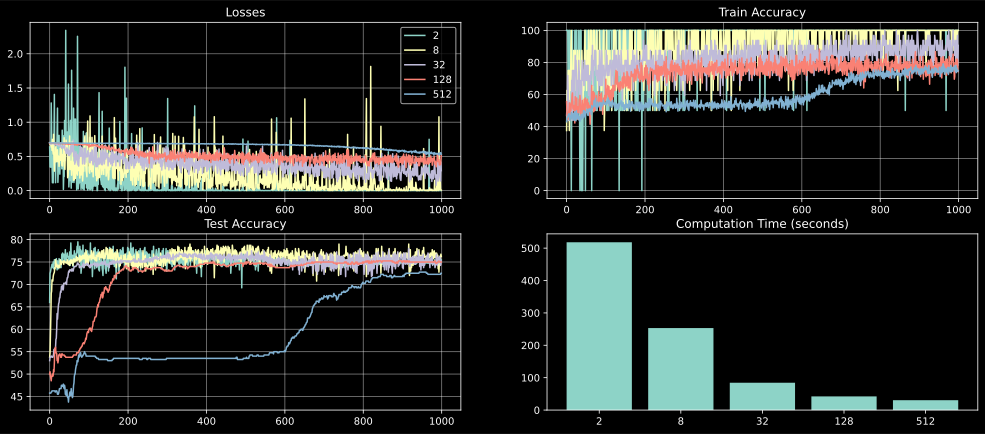

In [124]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(17,7))

axs = axs.flatten()

axs[0].plot(exp_losses)
axs[0].grid(alpha=0.5)
axs[0].legend(batch_sizes)
axs[0].set_title("Losses")

axs[1].set_title("Train Accuracy")
axs[1].plot(exp_train_accs)
axs[1].grid(alpha=0.5)

axs[2].set_title("Test Accuracy")
axs[2].plot(exp_test_accs)
axs[2].grid(alpha=0.5)

axs[3].set_title("Computation Time (seconds)")
axs[3].bar(range(len(comp_times)),comp_times,tick_label=batch_sizes);

# plt.ylim([50,100])
plt.show();

Podemos observar que efectivamente `batch_sizes` más altos son más rápidos, pero pueden también funcionar peor. La clave es una cantidad balanceada, como es 32 por ejemplo.